In [ ]:
# !pip install --upgrade diffusers[torch]
# !pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 22.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 99.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install translate
!pip install nltk
!pip install transformers  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from papago import papago_api, cleaned_text

import json
import nltk
import os
import sys
import re
import urllib.request
from translate import Translator
from typing import List, Dict
import argparse    
from nltk.data import load
from nltk.tokenize import word_tokenize  
# from utils import papago_api, cleaned_text   
from PIL import Image
import torch



nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
os.chdir('/content/drive/MyDrive/Colab Notebooks')  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## diffusion모델 부르기 

In [ ]:
!nvidia-smi
!pip install diffusers
!pip install --upgrade git+https://github.com/huggingface/diffusers.git transformers accelerate scipy xformers gradio -q

Wed Jan 25 13:00:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# naver_api 부르기 

In [ ]:
import json
import nltk
import os
import sys
import re
import urllib.request
from translate import Translator
from typing import List, Dict
import argparse    
from nltk.data import load
from nltk.tokenize import word_tokenize  

nltk.download('punkt')
client_id = "H4q5ybS5cfAmEl1hDUqC" # 개발자센터에서 발급받은 Client ID 값
client_secret = "w5KyEQhM2l" # 개발자센터에서 발급받은 Client Secret    

def papago_api(input_text, client, client_secret):
    encText = urllib.parse.quote(input_text)
    data = "source=ko&target=en&text=" + encText
    url = "https://openapi.naver.com/v1/papago/n2mt"
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    response = urllib.request.urlopen(request, data=data.encode("utf-8"))
    rescode = response.getcode()     
    if(rescode==200):
        response_body = response.read() 
        translated_text = response_body.decode('utf-8')
        dic = json.loads(translated_text)         
        text = dic['message']['result']['translatedText']         
        return text      
    else:
        print("Error Code:" + rescode)

def cleaned_text(translated_text, *args): 
    stop_words_list = list()  
    with open('stopwords.txt', 'r') as f:
        i = [line.strip() for line in f.readlines()]
        stop_words_list.append(i)   
    stop_words_list = stop_words_list[0]
    
    tokend_list = word_tokenize(translated_text)
    tokend_tagging_list = nltk.pos_tag(tokend_list)
    wanted_tagging_list = ["NN", "NNS", "NNP", "NNPS", "VB", "VBD", "VBG", "VBP", "VBZ"]  
    result_dic = dict()
    for tokened, tag in tokend_tagging_list:
        if tag in wanted_tagging_list:
            if tag not in result_dic:
                result_dic[tag] = [tokened]
            else:
                result_dic[tag].append(tokened)            
    prompt_text = " ".join(list(" ".join(v) for v in result_dic.values()))
    magic_words = ",".join(list(args))
    return prompt_text +" , "+magic_words


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 모델 부르기 

In [ ]:
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login

device = 'cuda'
notebook_login()

# # make sure you're logged in with `huggingface-cli login`
# pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True)  
# pipe = pipe.to("cuda")

Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4', revision='fp16',
    torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to(device)

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

# from text_to_img  해보기 

Magic words 

Quality words - HDR, UHD, 64K, Highly detailed<br>
Studio lighting  - Studio lighting<br>
professional  - professional<br>
Trending on artstation - Trending on artstation <br>
Unreal engine  - Unreal engine<br>
Vivid Colors - Vivid Colors<br>
Bokeh - Bokeh<br>
High resolution scan - High resolution scan<br>
Sketch - Sketch


# 예시 1

Let eat apple , 
Let's eat an apple.


  0%|          | 0/50 [00:00<?, ?it/s]

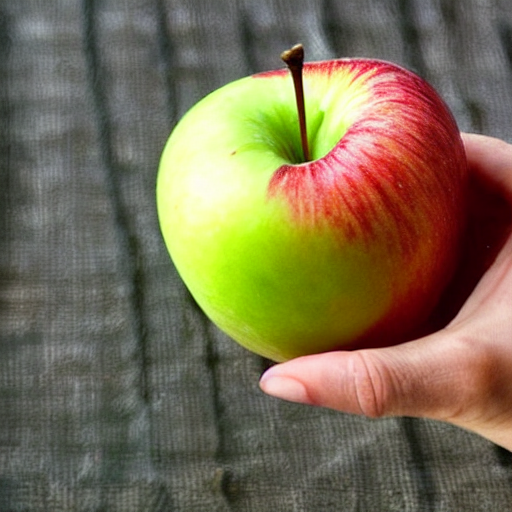

In [ ]:
# os.chdir('/content/drive/MyDrive/Colab Notebooks')  
translated_text = papago_api("사과를먹자", client_id, client_secret)    
prompt_text = cleaned_text(translated_text)
print(prompt_text)
print(translated_text)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

n_images = 1
prompts = [prompt_text] * n_images
with autocast(device):
  images = pipe(prompts, num_inference_steps=50).images
image_grid(images, rows=1, cols=1)

Let eat apple , HDR
Let's eat an apple.


  0%|          | 0/50 [00:00<?, ?it/s]

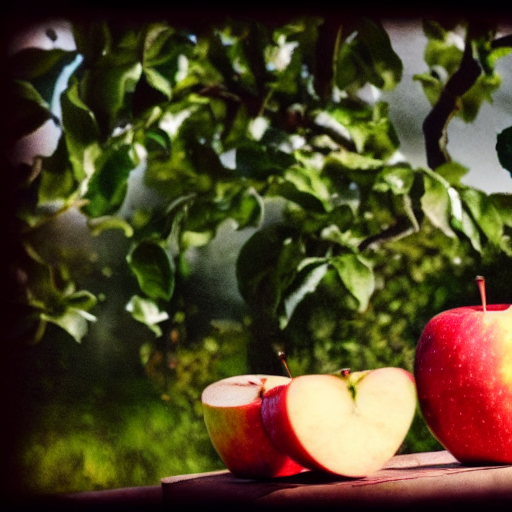

In [ ]:
# os.chdir('/content/drive/MyDrive/Colab Notebooks')  
translated_text = papago_api("사과를먹자", client_id, client_secret)    
prompt_text = cleaned_text(translated_text, 'HDR')
print(prompt_text)
print(translated_text)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

n_images = 1
prompts = [prompt_text] * n_images
with autocast(device):
  images = pipe(prompts, num_inference_steps=50).images
image_grid(images, rows=1, cols=1)

# 예시 2

girl girl eats Burger King , 
a girl who eats Burger King girl.


  0%|          | 0/50 [00:00<?, ?it/s]

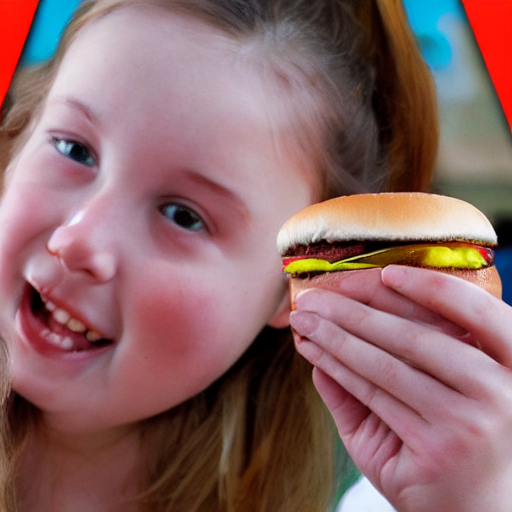

In [ ]:
# os.chdir('/content/drive/MyDrive/Colab Notebooks')  
translated_text = papago_api("버거킹을 먹는 여자아이", client_id, client_secret)    
prompt_text = cleaned_text(translated_text)
print(prompt_text)
print(translated_text)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

n_images = 1
prompts = [prompt_text] * n_images
with autocast(device):
  images = pipe(prompts, num_inference_steps=50).images
image_grid(images, rows=1, cols=1)

girl girl eats Burger King , Highly detailed,Vivid Colors
a girl who eats Burger King girl.


  0%|          | 0/50 [00:00<?, ?it/s]

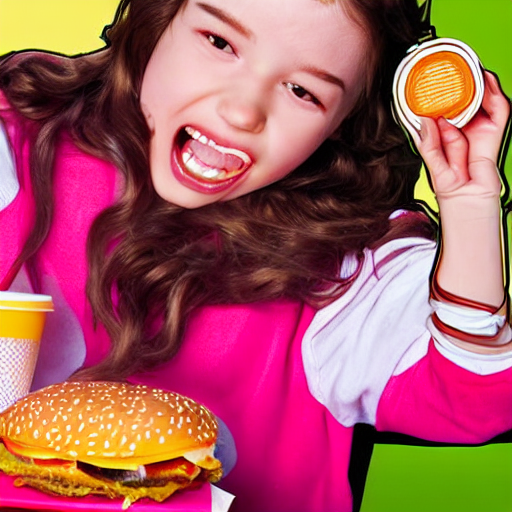

In [ ]:
# os.chdir('/content/drive/MyDrive/Colab Notebooks')  
translated_text = papago_api("버거킹을 먹는 여자아이", client_id, client_secret)    
prompt_text = cleaned_text(translated_text, 'Highly detailed', 'Vivid Colors')
print(prompt_text)
print(translated_text)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

n_images = 1
prompts = [prompt_text] * n_images
with autocast(device):
  images = pipe(prompts, num_inference_steps=50).images
image_grid(images, rows=1, cols=1)

# 예시 3

snowman scarf hat , 
a snowman in a scarf and a hat


  0%|          | 0/50 [00:00<?, ?it/s]

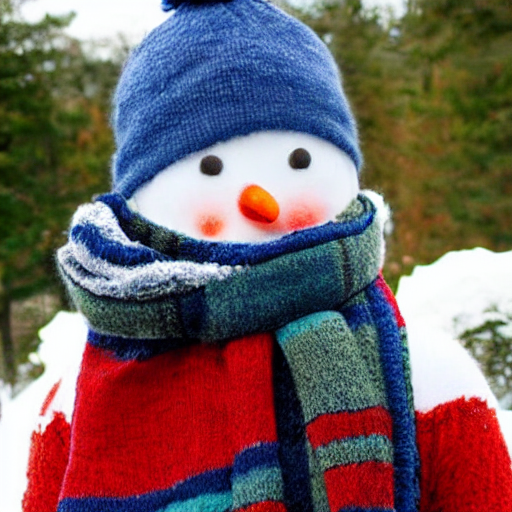

In [ ]:
# os.chdir('/content/drive/MyDrive/Colab Notebooks')  
translated_text = papago_api("목도리와 모자를 쓴 눈사람", client_id, client_secret)    
prompt_text = cleaned_text(translated_text)
print(prompt_text)
print(translated_text)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

n_images = 1
prompts = [prompt_text] * n_images
with autocast(device):
  images = pipe(prompts, num_inference_steps=50).images
image_grid(images, rows=1, cols=1)

snowman scarf hat , Sketch,Trending on artstation
a snowman in a scarf and a hat


  0%|          | 0/50 [00:00<?, ?it/s]

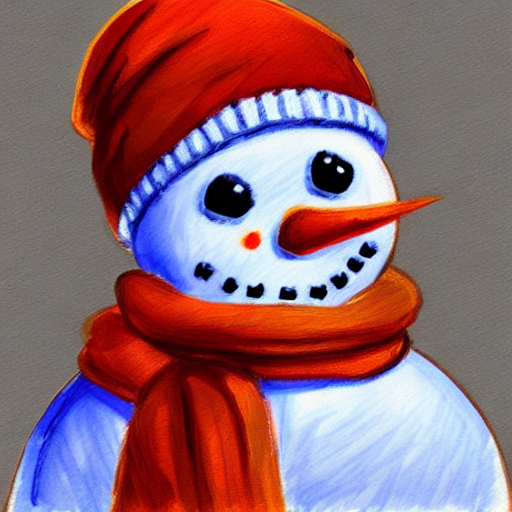

In [ ]:
# os.chdir('/content/drive/MyDrive/Colab Notebooks')  
translated_text = papago_api("목도리와 모자를 쓴 눈사람", client_id, client_secret)    
prompt_text = cleaned_text(translated_text,'Sketch', 'Trending on artstation' )
print(prompt_text)
print(translated_text)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

n_images = 1
prompts = [prompt_text] * n_images
with autocast(device):
  images = pipe(prompts, num_inference_steps=50).images
image_grid(images, rows=1, cols=1)

# 예시 4

sea sun rises , 
the sea where the sun rises


  0%|          | 0/50 [00:00<?, ?it/s]

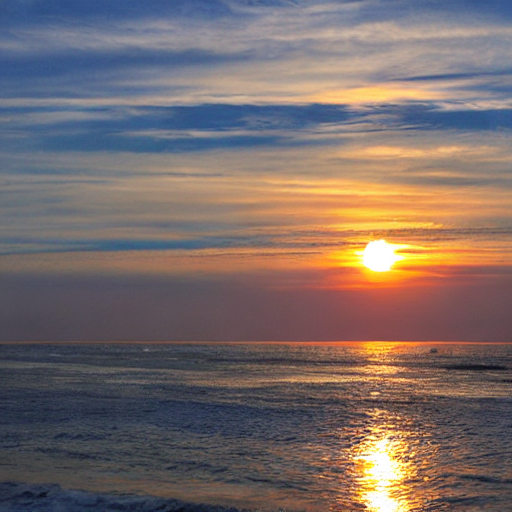

In [ ]:
# os.chdir('/content/drive/MyDrive/Colab Notebooks')  
translated_text = papago_api("해가 떠오르는 바다", client_id, client_secret)    
prompt_text = cleaned_text(translated_text)
print(prompt_text)
print(translated_text)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

n_images = 1
prompts = [prompt_text] * n_images
with autocast(device):
  images = pipe(prompts, num_inference_steps=50).images
image_grid(images, rows=1, cols=1)

sea sun rises ,  Unreal engine, High resolution scan
the sea where the sun rises


  0%|          | 0/50 [00:00<?, ?it/s]

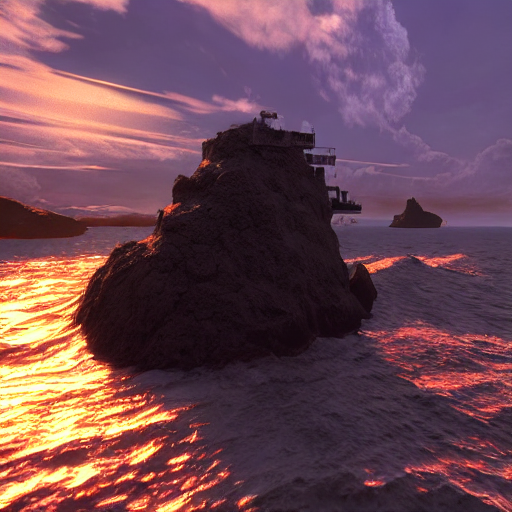

In [ ]:
# os.chdir('/content/drive/MyDrive/Colab Notebooks')  
translated_text = papago_api("해가 떠오르는 바다", client_id, client_secret)    
prompt_text = cleaned_text(translated_text, ' Unreal engine', ' High resolution scan' )
print(prompt_text)
print(translated_text)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

n_images = 1
prompts = [prompt_text] * n_images
with autocast(device):
  images = pipe(prompts, num_inference_steps=50).images
image_grid(images, rows=1, cols=1)

girl playing playground , 
A girl and a boy playing in the playground.


  0%|          | 0/50 [00:00<?, ?it/s]

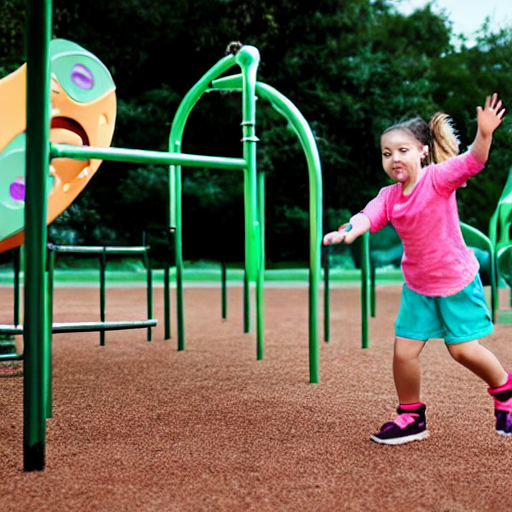

In [ ]:
# 예시 5 

# os.chdir('/content/drive/MyDrive/Colab Notebooks')  
translated_text = papago_api("놀이터에서 놀고 있는 소녀와 소년", client_id, client_secret)    
prompt_text = cleaned_text(translated_text)
print(prompt_text)
print(translated_text)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

n_images = 1
prompts = [prompt_text] * n_images
with autocast(device):
  images = pipe(prompts, num_inference_steps=50).images
image_grid(images, rows=1, cols=1)

girl playing playground , professional
A girl and a boy playing in the playground.


  0%|          | 0/50 [00:00<?, ?it/s]

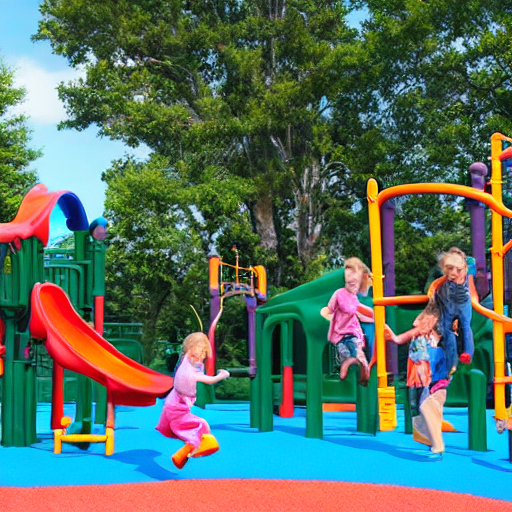

In [ ]:
# 예시 5 

# os.chdir('/content/drive/MyDrive/Colab Notebooks')  
translated_text = papago_api("놀이터에서 놀고 있는 소녀와 소년", client_id, client_secret)    
prompt_text = cleaned_text(translated_text, 'professional')
print(prompt_text)
print(translated_text)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

n_images = 1
prompts = [prompt_text] * n_images
with autocast(device):
  images = pipe(prompts, num_inference_steps=50).images
image_grid(images, rows=1, cols=1)